In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Figures:** 
* Figure: Number of mutations per person 


**Statistics:**
* Number of total families included after filtering
* Total number of mutations passing filters
* Percent of mutations that are expansions vs. contractions
* Number of mutations per healthy child
* Correlation of mutation counts wihin family
* Correlation of # mutations with paternal and maternal age
* Ratio of paternal:maternal mutations

In [35]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

MUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/SSC_allphases_072820_denovos_model_X.denovos.final_qc_mutations.tab"
NAIVEMUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_072820_denovos_naive_X.denovos.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats

# Other input data
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation.bed" #includes X


# Output path info
OUTDIR = "/storage/ileena/pdfs/"

In [4]:
def GetCounts(df, pt):
    counts = df[df["phenotype"]==pt]
    return counts.groupby("child").size().tolist()


def CaseControlTest(data):
    # 1 unaffected, 2 affected
    aff_counts = GetCounts(data, 2)
    unaff_counts = GetCounts(data, 1)
#     p = scipy.stats.ttest_rel(unaff_counts, aff_counts)[1]
    p = scipy.stats.mannwhitneyu(unaff_counts, aff_counts,  alternative="less")[1]
    # Stats
    print("Healthy child - median=%s mean=%s"%(np.median(unaff_counts), np.mean(unaff_counts)))
    print("ASD child - median=%s mean=%s"%(np.median(aff_counts), np.mean(aff_counts)))
    mean_num_muts = np.mean(data.groupby("child").size().tolist())
    print("Total average = %s"%(mean_num_muts))
    print("MannWhitney test p= %s"%(p))



In [5]:
# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])
alldata = pd.concat([alldata,pd.read_csv(MUTFILEX, sep="\t")], sort=False)
alldata = alldata[alldata.family.isin(usefams)]


# Load expansions identified using naive method
ndata = pd.concat([pd.read_csv(NAIVEMUTFILE, sep="\t"),
                   pd.read_csv(NAIVEMUTFILEX, sep="\t")], sort=False)
# moderately big expansion events
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)].copy() 

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata]).drop_duplicates()


# Manually remove remaining problematic families.
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]


# Age data
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages = ages[~np.isnan(ages["father_age_birth"])]


alldata = pd.merge(alldata, ages, on=["family", "child"], how="left")

In [8]:
### Autosomes + X
# Number of unique families, children
print("Number of unique families: %s"%len(set(alldata["family"])))
print("Number of unique children: %s"%len(set(alldata["child"])))

# Number of unique TRs
print("Number of unique TRs: %s"%len(alldata[["chrom", "pos", "period"]].drop_duplicates()))

# Total number of mutations
print("Number of total mutations: %s"%alldata.shape[0])

Number of unique families: 1593
Number of unique children: 3186
Number of unique TRs: 93880
Number of total mutations: 174330


In [12]:
### Autosomes + X

# How many mutations are expansions vs. contractions
print("Percent expansions: %s"%np.mean(alldata["mutsize"]>0))
print("Binomial pval=%s"%scipy.stats.binom_test(np.sum(alldata["mutsize"]>0), n=alldata.shape[0], p=0.5))
print("Percent expansions - no homopolymers: %s"%np.mean(alldata[alldata["period"]>1]["mutsize"]>0))
print("Binomial pval=%s"%scipy.stats.binom_test(np.sum(alldata[alldata["period"]>1]["mutsize"]>0), n=alldata[alldata["period"]>1].shape[0], p=0.5))
print("Number non-homopolymer mutations: %s"%alldata[alldata["period"]>1].shape[0])

# Cases vs controls
aff_counts = GetCounts(alldata, 2)
unaff_counts = GetCounts(alldata, 1)

# Stats
CaseControlTest(alldata)


Percent expansions: 0.704778294040039
pval=1.5e-323
Percent expansions - no homopolymers: 0.5617690457973549
pval=1.7800208895001996e-245
Number non-homopolymer mutations: 73192
Healthy child - median=54.0 mean=54.204017576898934
ASD child - median=55.0 mean=55.23101067168864
MW pval=0.01361597989707093


# Number of CHR X mutations per person

In [17]:
#### X chrom
x = alldata[alldata.chrom=="X"].copy()

### Autosomes + X
# Number of unique families, children
print("Number of unique families: %s"%len(set(x["family"])))
print("Number of unique children: %s"%len(set(x["child"]))) ##note some families do not have both proband & sibling

# Number of unique TRs
print("Number of unique TRs: %s"%len(x[["chrom", "pos", "period"]].drop_duplicates()))

# Total number of mutations
print("Number of total mutations: %s"%x.shape[0])

# How many mutations are expansions vs. contractions
print("Percent expansions: %s"%np.mean(x["mutsize"]>0))
print("Binomial pval=%s"%scipy.stats.binom_test(np.sum(x["mutsize"]>0), n=x.shape[0], p=0.5))
print("Percent expansions - no homopolymers: %s"%np.mean(x[x["period"]>1]["mutsize"]>0))
print("Binomial pval=%s"%scipy.stats.binom_test(np.sum(x[x["period"]>1]["mutsize"]>0), n=x[x["period"]>1].shape[0], p=0.5))
print("Number non-homopolymer mutations: %s"%x[x["period"]>1].shape[0])

# Cases vs controls
aff_counts = GetCounts(x, 2)
unaff_counts = GetCounts(x, 1)

# Stats
CaseControlTest(x)



Number of unique families: 1196
Number of unique children: 1566
Number of unique TRs: 1955
Number of total mutations: 2752
Percent expansions: 0.59375
Binomial pval=7.14602846489797e-23
Percent expansions - no homopolymers: 0.5072992700729927
Binomial pval=0.6077393607514572
Number non-homopolymer mutations: 1370
Healthy child - median=2.0 mean=1.9083333333333334
ASD child - median=1.0 mean=1.518151815181518
MW pval=1.0
Healthy child - median=2.0 mean=1.9083333333333334
ASD child - median=1.0 mean=1.518151815181518
Total average = 1.7573435504469987
MannWhitney test p= 1.0


Healthy child - median=2.0 mean=1.9083333333333334
ASD child - median=1.0 mean=1.518151815181518
Total average = 1.7573435504469987
MannWhitney test p= 1.0


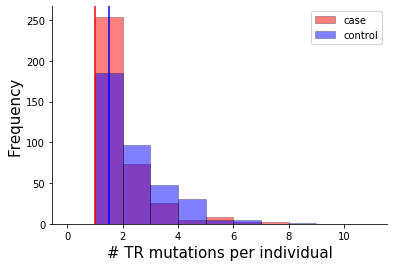

In [15]:
#### X chrom
# Get number of mutations per sample
mut_ctrl = x[x["phenotype"]==1].groupby(["family"], as_index=False).agg({"child": len})
mut_ctrl.columns = ["family","num_ctrl"]
mut_case = x[x["phenotype"]==2].groupby(["family"], as_index=False).agg({"child": len})
mut_case.columns = ["family","num_case"]
famdata = pd.merge(mut_ctrl, mut_case, on=["family"])

# Plot number of mutations per sample histogram
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(famdata["num_case"], color="red", alpha=0.5, bins=np.arange(0, max(famdata["num_case"])+5, 1), edgecolor="black", linewidth=0.5, label="case");
ax.hist(famdata["num_ctrl"], color="blue", alpha=0.5, bins=np.arange(0, max(famdata["num_case"])+5, 1), edgecolor="black", linewidth=0.5, label="control");

ax.set_xlabel("# TR mutations per individual", size=15);
ax.set_ylabel("Frequency", size=15);
ax.axvline(x=np.median(famdata["num_case"]), color="red", linestyle="solid")
ax.axvline(x=np.median(famdata["num_ctrl"]), color="blue", linestyle="solid")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.legend(loc="upper right")
fig.savefig(os.path.join(OUTDIR, "Figure1_NumDenovos-X.pdf"))


# Number of CHR X mutations per person by sex

In [22]:
#### X chrom by sex
sex = "female"
xsex = alldata[(alldata.chrom=="X") & (alldata.sex==sex)].copy()

### Autosomes + xsex
# Number of unique families, children
print("Number of unique families: %s"%len(set(xsex["family"])))
print("Number of unique children: %s"%len(set(xsex["child"]))) ##note some families do not have both proband & sibling same sex

# Number of unique TRs
print("Number of unique TRs: %s"%len(xsex[["chrom", "pos", "period"]].drop_duplicates()))

# Total number of mutations
print("Number of total mutations: %s"%xsex.shape[0])

# How many mutations are exsexpansions vs. contractions
print("Percent exsexpansions: %s"%np.mean(xsex["mutsize"]>0))
print("Binomial pval=%s"%scipy.stats.binom_test(np.sum(xsex["mutsize"]>0), n=xsex.shape[0], p=0.5))
print("Percent exsexpansions - no homopolymers: %s"%np.mean(xsex[xsex["period"]>1]["mutsize"]>0))
print("Binomial pval=%s"%scipy.stats.binom_test(np.sum(xsex[xsex["period"]>1]["mutsize"]>0), n=xsex[xsex["period"]>1].shape[0], p=0.5))
print("Number non-homopolymer mutations: %s"%xsex[xsex["period"]>1].shape[0])

# Cases vs controls
aff_counts = GetCounts(xsex, 2)
unaff_counts = GetCounts(xsex, 1)

# Stats
print(sex, "Stats:")
CaseControlTest(xsex)


Number of unique families: 793
Number of unique children: 861
Number of unique TRs: 1441
Number of total mutations: 1883
Percent exsexpansions: 0.667020711630377
Binomial pval=2.3773024905084238e-48
Percent exsexpansions - no homopolymers: 0.572605561277034
Binomial pval=6.786800070109127e-06
Number non-homopolymer mutations: 971
female Stats:
Healthy child - median=2.0 mean=2.1564722617354195
ASD child - median=2.0 mean=2.3227848101265822
Total average = 2.186991869918699
MannWhitney test p= 0.23136672694871518


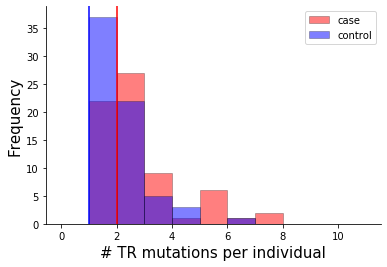

In [23]:
####  X chrom by sex

# Get number of mutations per sample
mut_ctrl = xsex[xsex["phenotype"]==1].groupby(["family"], as_index=False).agg({"child": len})
mut_ctrl.columns = ["family","num_ctrl"]
mut_case = xsex[xsex["phenotype"]==2].groupby(["family"], as_index=False).agg({"child": len})
mut_case.columns = ["family","num_case"]
famdata = pd.merge(mut_ctrl, mut_case, on=["family"])

# Plot number of mutations per sample histogram
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(famdata["num_case"], color="red", alpha=0.5, bins=np.arange(0, max(famdata["num_case"])+5, 1), edgecolor="black", linewidth=0.5, label="case");
ax.hist(famdata["num_ctrl"], color="blue", alpha=0.5, bins=np.arange(0, max(famdata["num_case"])+5, 1), edgecolor="black", linewidth=0.5, label="control");

ax.set_xlabel("# TR mutations per individual", size=15);
ax.set_ylabel("Frequency", size=15);
ax.axvline(x=np.median(famdata["num_case"]), color="red", linestyle="solid")
ax.axvline(x=np.median(famdata["num_ctrl"]), color="blue", linestyle="solid")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.legend(loc="upper right")
fig.savefig(os.path.join(OUTDIR, "Figure1_NumDenovos-X.pdf"))

# Number of CHR X mutations annotations 

In [43]:
# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(x, annot, on=["chrom","pos", "period"])
col = 'FEATURE-CODING'
out = adata[(adata[col]>0)].sort_values(["chrom", "pos", "period", "family"]).drop_duplicates()
print(col, out.shape[0])
out[["phenotype", "chrom", "pos", "mutsize", "motif", "gene-coding"]]

FEATURE-CODING 1


,phenotype,chrom,pos,mutsize,motif,gene-coding
280,2,X,136502889,-1,AAG,HTATSF1
